# Track.ipynb
Author: Yueqian Lin


In [1]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl
import matplotlib.pyplot as plt

# change the following to %matplotlib notebook for interactive plotting
%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(14, 14))
mpl.rc('image', cmap='gray')
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience

import pims
import trackpy as tp

In [2]:
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

# frames = (pims.open('/home/yl768/UVM_H/images/46k_105C/*.tif'))
frames = (pims.open('/home/yl768/UVM_H/images/100k_95C/*.tif'))

In [3]:
import pandas as pd
import os
 
# path
path = '/home/yl768/UVM_H/output/100K_100/'
 
# file list
files = []
for file in os.listdir(path):
    if file.endswith(".txt"):
        files.append(path+file)
files.sort()
overall=pd.DataFrame()
j=0
for i in files:

    data = pd.read_csv(i,sep=' ', header=None)

    data[4]=(data[0]+data[2])/2
    data[5]=(data[1]+data[3])/2
    data.columns = ["Xmin", "Ymin", "Xmax", "Ymax", "x", "y"]
    data.to_csv(i[:-3]+'csv',na_rep='NA')
    data['size']=(data['Xmax']-data['Xmin'])*(data['Ymax']-data['Ymin'])
    data['frame']=j
    data=data[['x','y','size','frame']]
    j=j+1
    overall=overall.append(data, ignore_index=True)
#sort_list = data_count_list.reset_index().sort_values('price',ascending = False).set_index('course_id')

In [4]:
overall

,x,y,size,frame
0,775.0,51.0,252,0
1,1223.5,428.5,165,0
2,1074.5,1913.0,204,0
3,1401.0,1675.5,182,0
4,378.5,1086.5,143,0
...,...,...,...,...
4232,1043.5,1462.5,187,22
4233,94.5,1871.0,110,22
4234,705.0,1744.0,120,22
4235,324.0,851.0,144,22


In [41]:
overall.to_csv(path+"100K_95C_NP_overall.csv")

In [5]:
# link the point to trajectgory try diiferent values of the parameters! (memory means how many images it memorize 
# before finding the next occurence)
t = tp.link(overall,22, memory=22)

Frame 22: 181 trajectories present.


In [6]:
# filter the trajectory by how many numbers of frames in total it shows up
t1 = tp.filter_stubs(t, 17 )
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t1['particle'].nunique())

Before: 805
After: 51


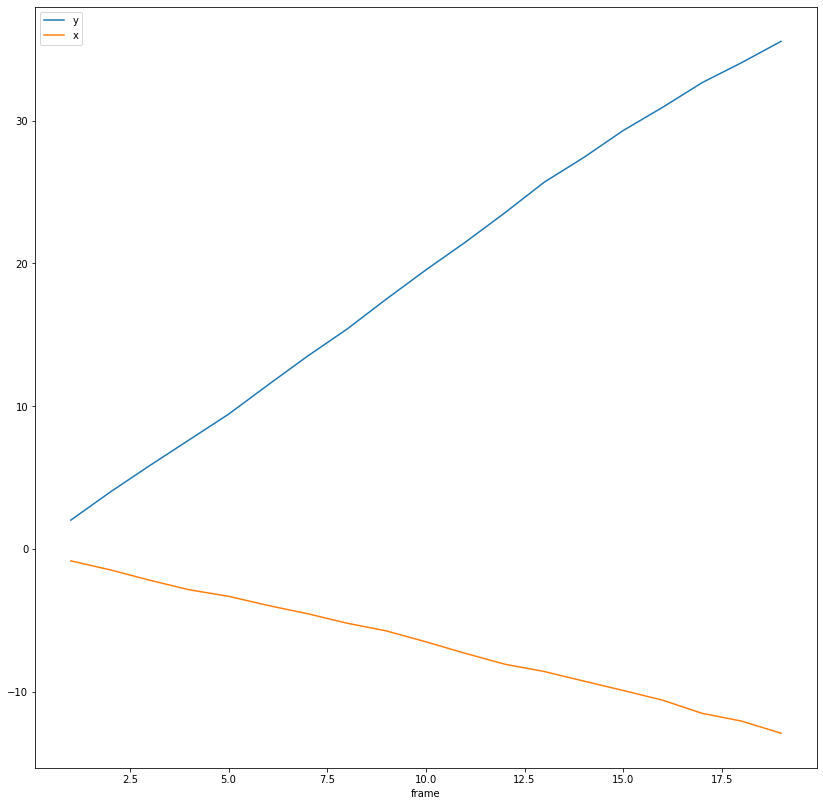

In [92]:
# we don't compute drift now
d = tp.compute_drift(t)
plot=d.plot()
plt.show()
fig = plot.get_figure()
#fig.savefig("output.png",bbox_inches = 'tight',dpi=fig.dpi,pad_inches=0.0)
fig.savefig(path+"100k_drift.png",bbox_inches = 'tight',dpi=fig.dpi)


In [94]:
d.to_csv(path+'100k_drift.csv')

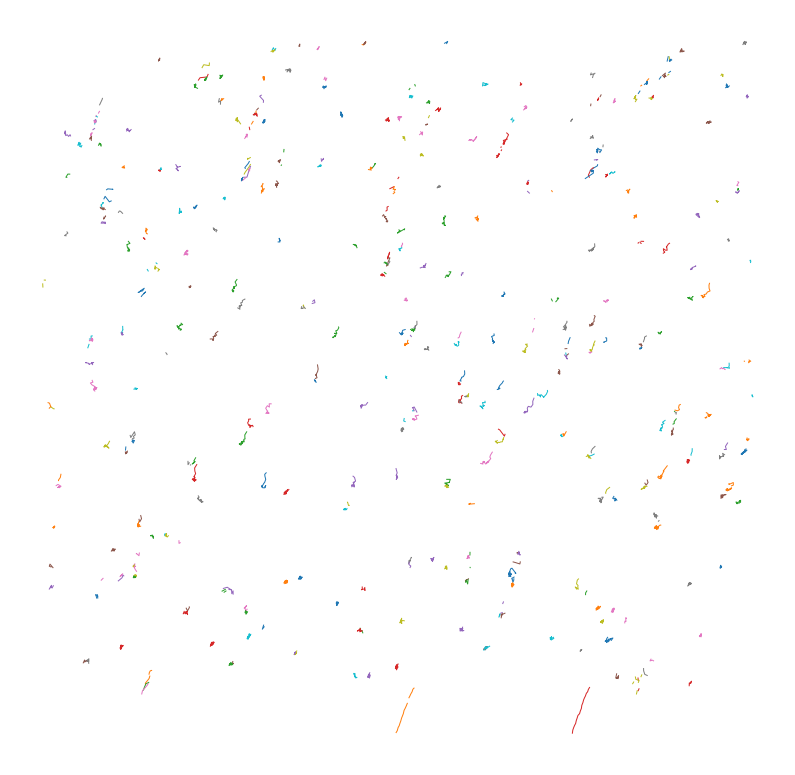

In [95]:
tm = tp.subtract_drift(t1.copy(), d)
plt.figure(figsize=(14, 14))
plt.xticks([]) # 不显示x轴
plt.yticks([]) # 不显示y轴
plt.axis('off')
plot=tp.plot_traj(tm)
plt.show()
fig = plot.get_figure()
#fig.savefig("output.png",bbox_inches = 'tight',dpi=fig.dpi,pad_inches=0.0)
fig.savefig(path+"100k_without_drift.png",bbox_inches = 'tight',dpi=fig.dpi)

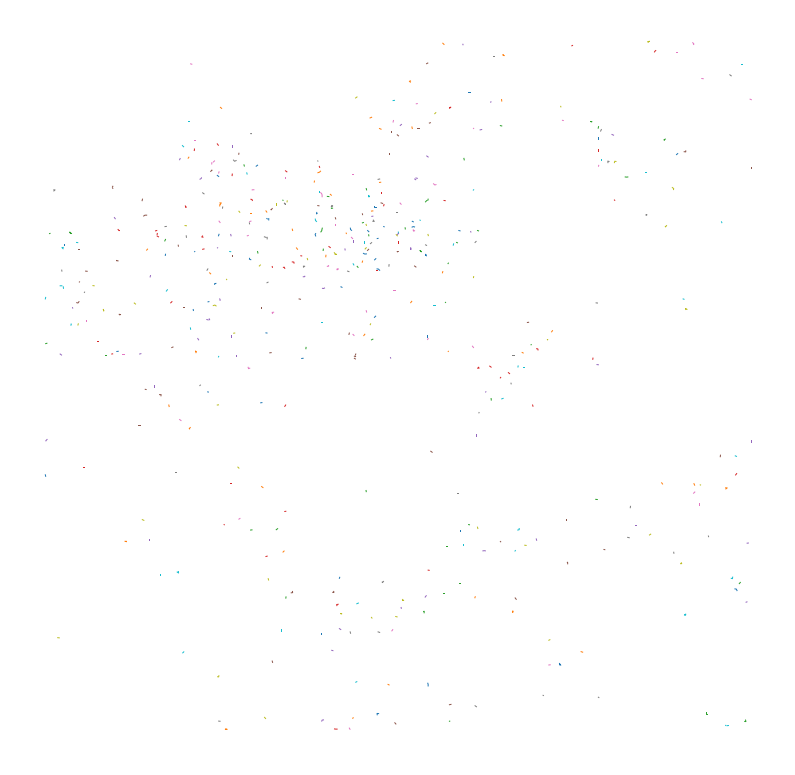

In [36]:
# plt.figure(dpi=600,figsize=(4, 4))
plt.xticks([]) # 不显示x轴
plt.yticks([]) # 不显示y轴
plt.axis('off')
plot = tp.plot_traj(t1)
fig = plot.get_figure()
#fig.savefig("output.png",bbox_inches = 'tight',dpi=fig.dpi,pad_inches=0.0)
fig.savefig(path+"100k_with_drift.png",bbox_inches = 'tight',dpi=fig.dpi)


In [96]:
import cv2

# Change the image background to white
def transparence2white(img):
    sp=img.shape 
    width=sp[0]  
    height=sp[1]  
    for yh in range(height):
        for xw in range(width):
            color_d=img[xw,yh] 
            if(color_d[3]==0):  
                img[xw,yh]=[255,255,255,255]  
    return img

img=cv2.imread(path+"100k_without_drift.png",-1)  
img=transparence2white(img)  
cv2.imwrite(path+"100k_without_drift_white_background.png",img)  



True

In [7]:
# export the trajectory
from PIL import Image, ImageDraw

df=t1
df=df.sort_values(by='particle')
df['color']=None
df
j=0
tmp=0
color="red"

 

data=df.sort_values(by='particle')
data.set_index(['particle','frame',],inplace=True)
data.sort_index(inplace=True)


df=data.reset_index(level=1)
tmp=0
j=0
# we don't draw the lines now
# for i in range(df.shape[0]-1):
#     if (tmp!=j): 

#         tmp=j
#     if (j==df.index[i] and j==df.index[i+1]):
#         draw.line((df.iloc[i,1], df.iloc[i,2],df.iloc[i+1,1],df.iloc[i+1,2]) ,df.iloc[i,4], width=3) #线的起点和终点，线宽
#     else:
#         j=j+1
import math
j=df.index[0]
tmp=False
minx=0
miny=0
maxx=0
maxy=0
df['distance']=None
for i in range(df.shape[0]+1):
    if i == df.shape[0]:
        maxx=df.iloc[i-1,1]
        maxy=df.iloc[i-1,2]
        print(minx,maxx)
#         color=getColor()
        df.iloc[i-1,5]=(math.sqrt((maxx-minx)**2+(maxy-miny)**2))
        break
    if (j==df.index[i]):
        if tmp == False:
            minx=df.iloc[i,1]
            miny=df.iloc[i,2]
        tmp=True  
    else:
        tmp=False
        
        j=df.index[i]
        maxx=df.iloc[i-1,1]
        maxy=df.iloc[i-1,2]
        print(minx,maxx)
#         color=getColor()
        df.iloc[i-1,5]=(math.sqrt((maxx-minx)**2+(maxy-miny)**2))
        
        #draw.line((minx, miny,maxx,maxy) ,color, width=3)
#         draw.text((minx,miny),str(np.format_float_positional((df.iloc[i-1,5]/250), precision=2, unique=True, fractional=False, trim='-')), fill =df.iloc[i-1,4])
        minx=0
        miny=0
        maxx=0
        maxy=0

        
# img1.save("distance6.png")






444.0 436.5
1289.5 1274.0
1875.0 1854.0
1790.0 1782.0
1347.0 1332.5
451.0 444.0
1983.0 1959.5
437.0 428.0
1967.0 1944.5
962.0 951.5
1109.5 1104.5
2033.0 2009.0
1613.0 1601.5
2009.0 1985.5
447.5 444.0
1050.5 1040.5
1828.0 1812.0
1066.5 1056.0
101.5 101.0
1501.5 1494.0
424.0 420.5
436.0 428.5
232.5 224.0
873.5 866.5
471.0 460.0
1609.0 1597.0
1151.5 1140.5
1413.0 1401.5
1220.5 1209.0
1394.0 1378.0
1289.5 1278.0
1079.0 1067.0
1059.5 1048.0
654.5 651.0
1021.0 1013.0
1355.5 1343.5
935.5 936.0
2109.0 2085.5
201.5 205.0
956.0 951.0
921.0 913.0
1151.5 1140.0
525.5 517.0
1959.0 1925.0
628.0 620.5
913.5 905.5
1766.0 1743.5
1797.0 1774.5
509.5 502.0
574.0 567.5
971.0 958.5


In [9]:
# * a coefficient to get the distance in um
df['distance(um)']=None
for i in range(df.shape[0]):
    if df.iloc[i,5]!= None:
        df.iloc[i,6]=df.iloc[i,5]/128
a=df[['frame','x','y','size','distance','distance(um)']]
a.to_excel(path+'1100k_distance_with_drift-new.xls')

In [86]:
a.tail()

,frame,x,y,size,distance,distance(um)
particle,,,,,,
2205,19,523.128339,520.335822,56,0.70209,0.00548508
2206,16,138.229533,442.274655,70,None,None
2206,17,137.668785,442.805029,56,None,None
2206,18,136.311967,440.298211,72,None,None
2206,19,138.628339,440.835822,72,2.19055,0.0171137
